TASK 2: CONVENTIONAL AUGMENTATION

Augmentation started at: 2026-02-06 13:21:01

DEMONSTRATING AUGMENTATION TECHNIQUES


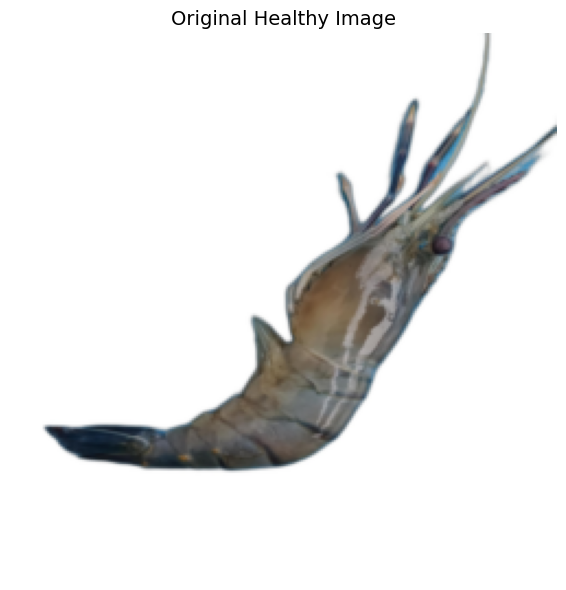

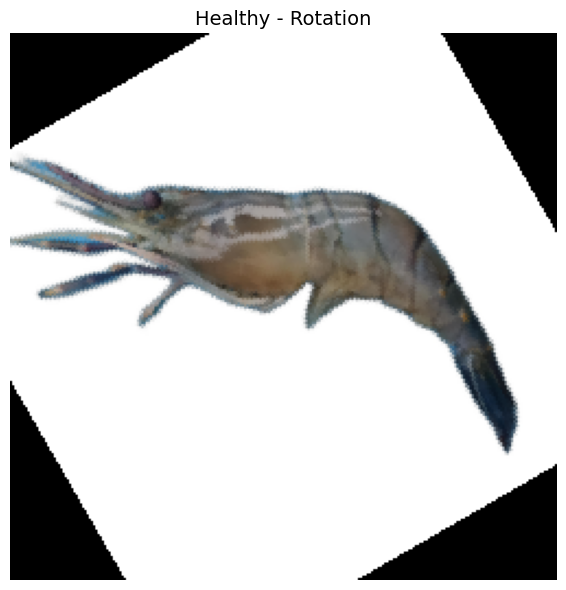

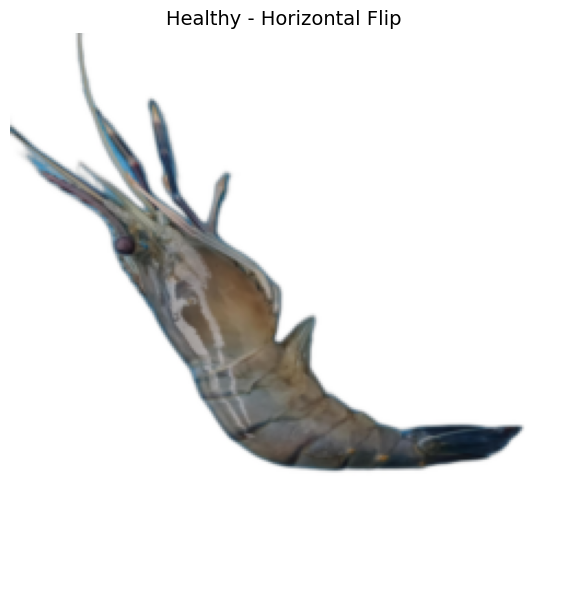

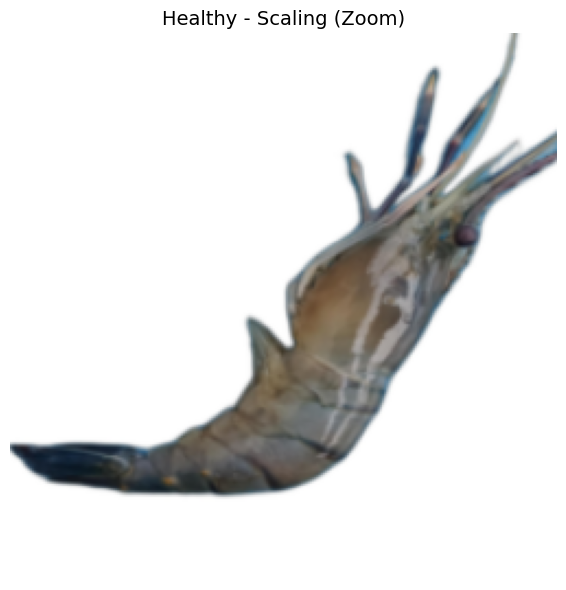

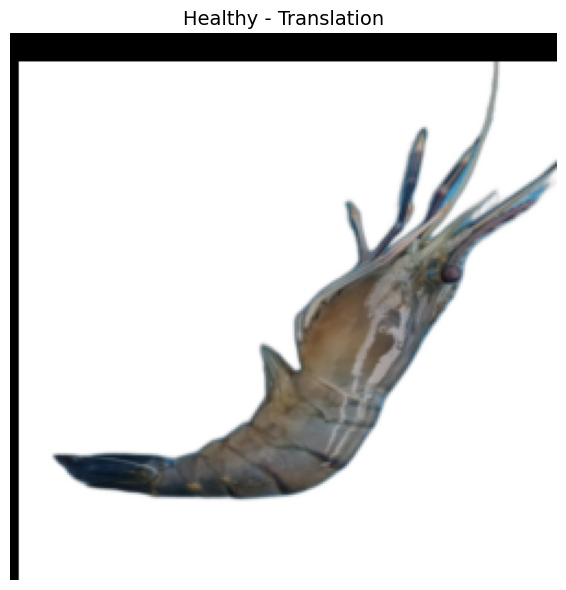

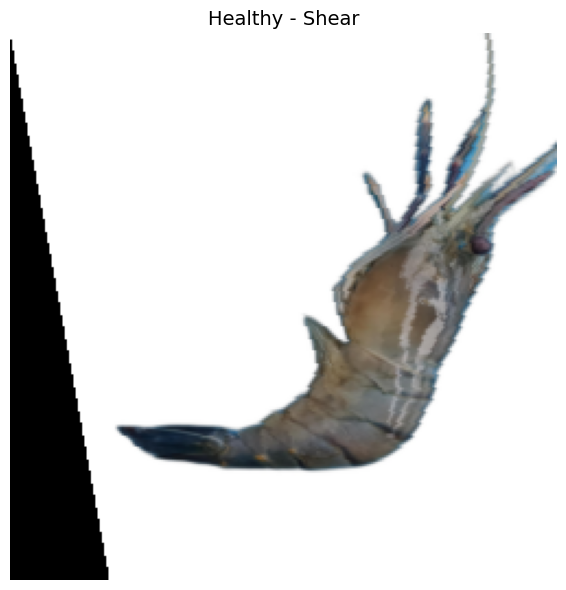

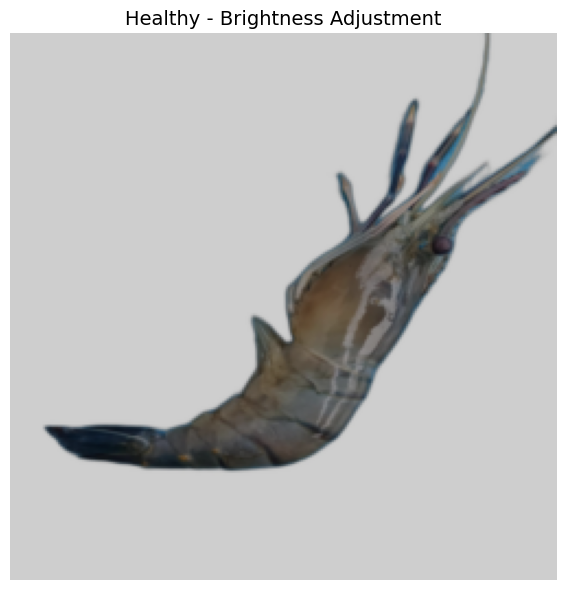

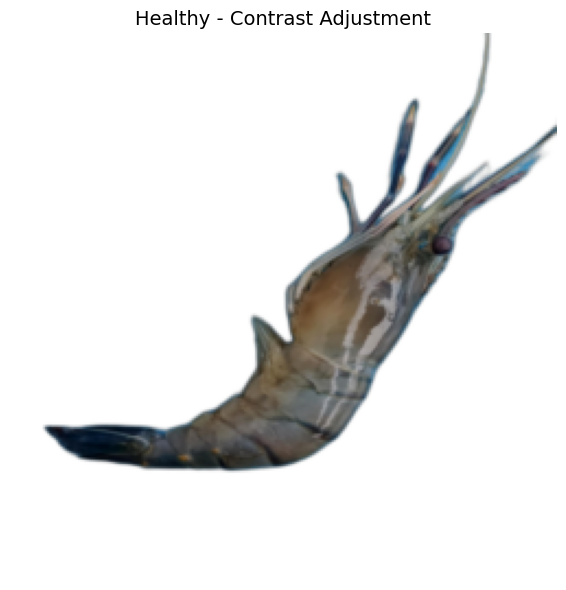

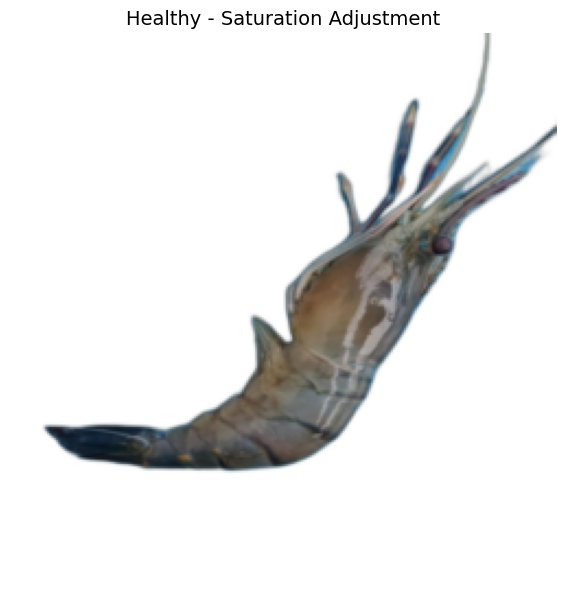

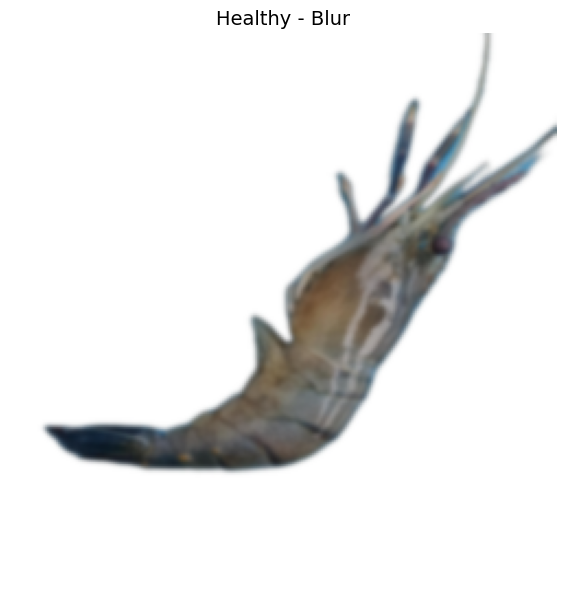

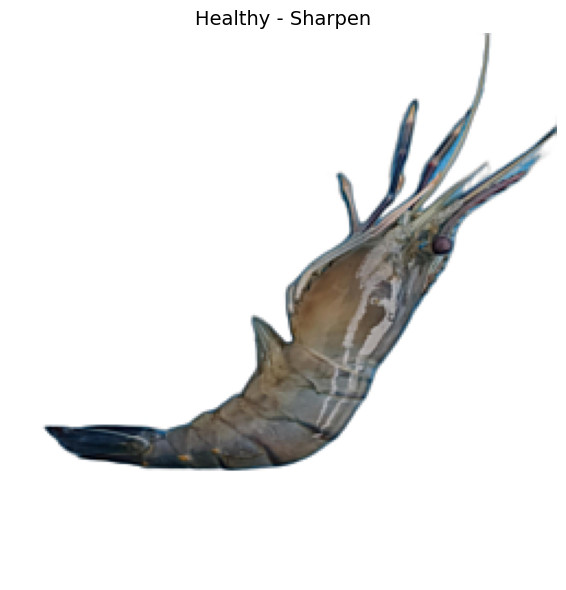

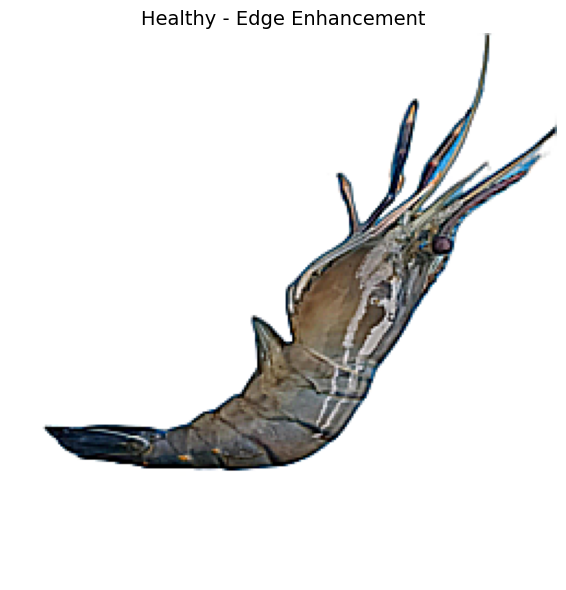


AUGMENTING DATASET

Processing class: BG
Original images: 198
Target images: 2500
Need to generate: 2302 augmented images
Copying original images...
Generating 2302 augmented images...
  Generated 100/2302 images...
  Generated 200/2302 images...
  Generated 300/2302 images...
  Generated 400/2302 images...
  Generated 500/2302 images...
  Generated 600/2302 images...
  Generated 700/2302 images...
  Generated 800/2302 images...
  Generated 900/2302 images...
  Generated 1000/2302 images...
  Generated 1100/2302 images...
  Generated 1200/2302 images...
  Generated 1300/2302 images...
  Generated 1400/2302 images...
  Generated 1500/2302 images...
  Generated 1600/2302 images...
  Generated 1700/2302 images...
  Generated 1800/2302 images...
  Generated 1900/2302 images...
  Generated 2000/2302 images...
  Generated 2100/2302 images...
  Generated 2200/2302 images...
  Generated 2300/2302 images...
Class BG completed! Total images: 2500

Processing class: Healthy
Original images: 403


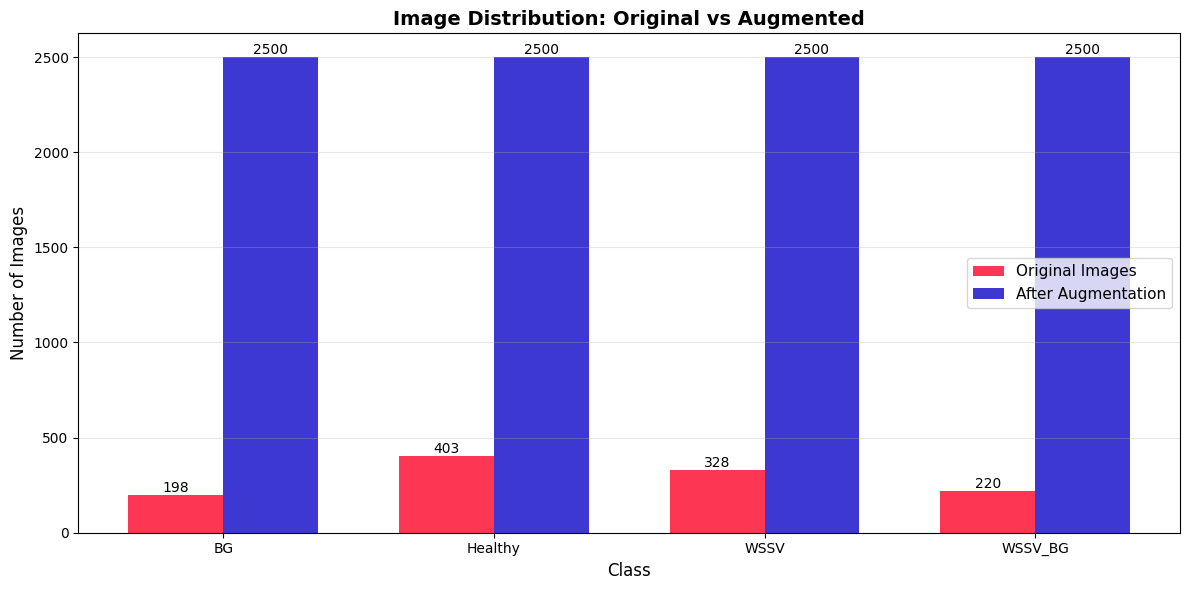


VISUALIZING AUGMENTED IMAGE PREPROCESSING


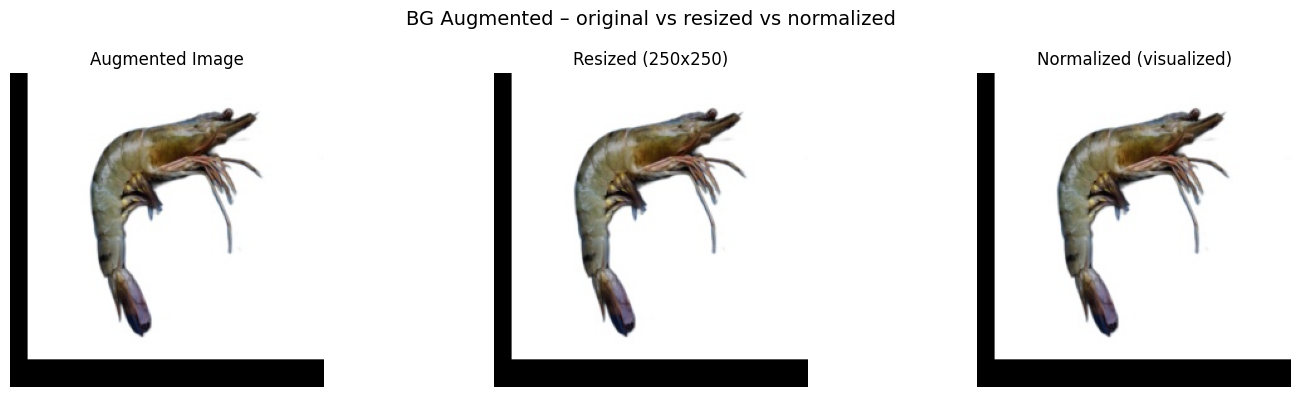

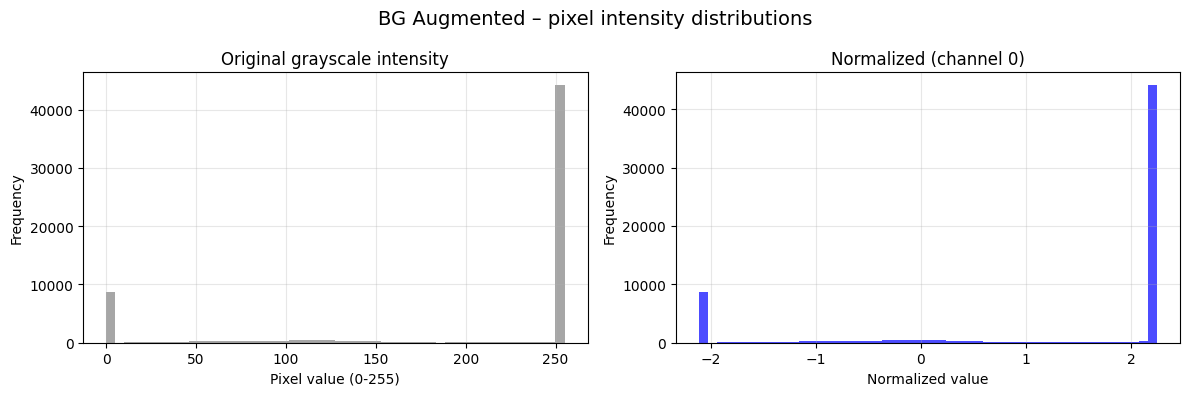

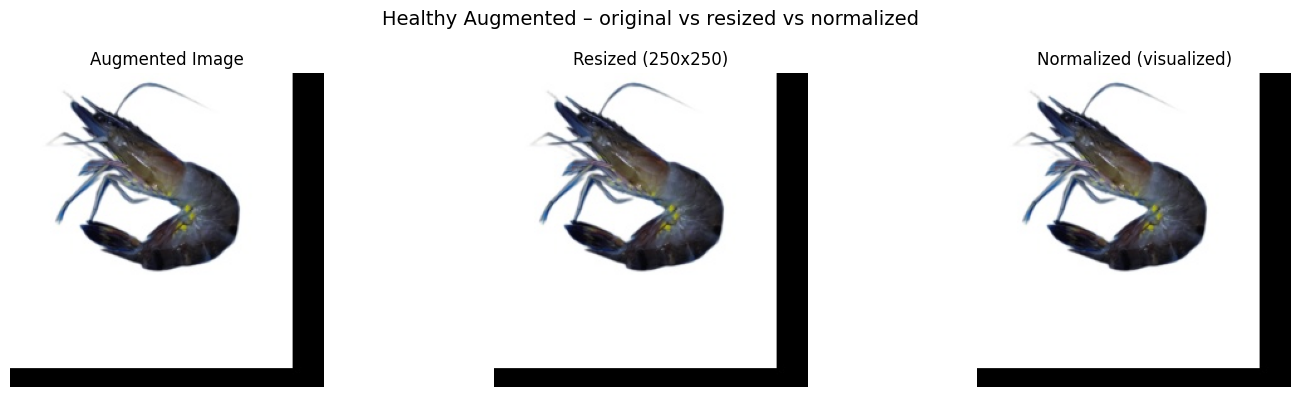

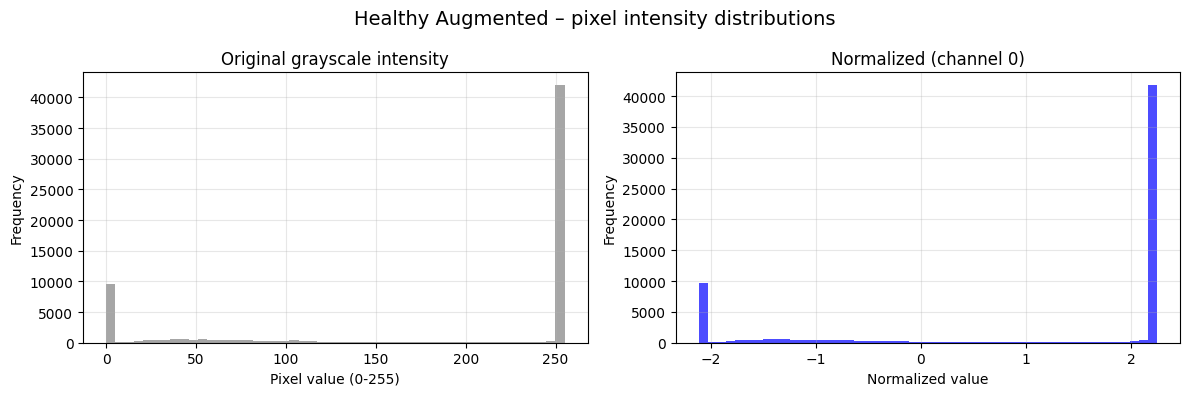

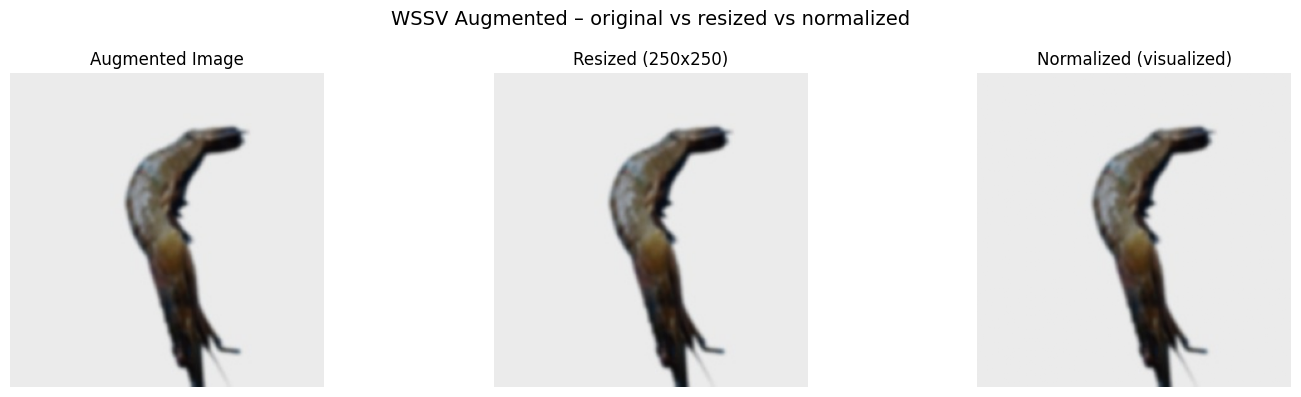

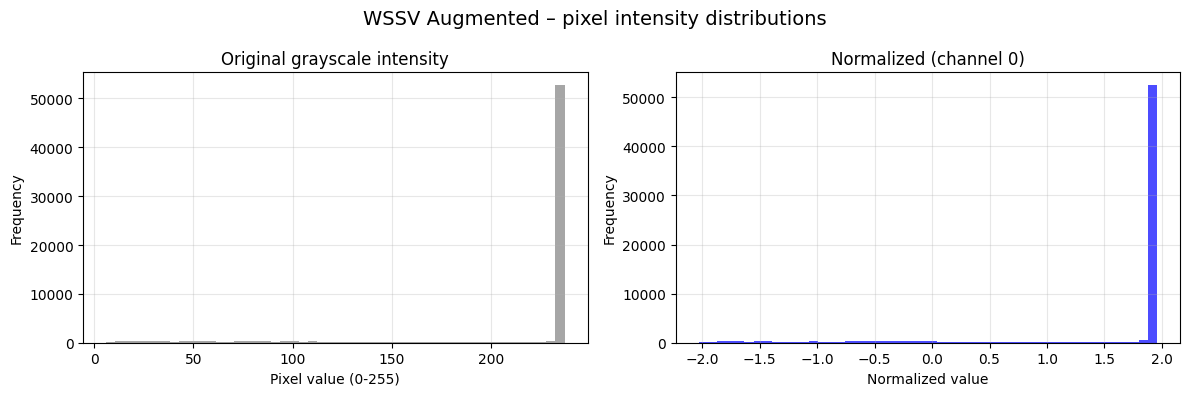

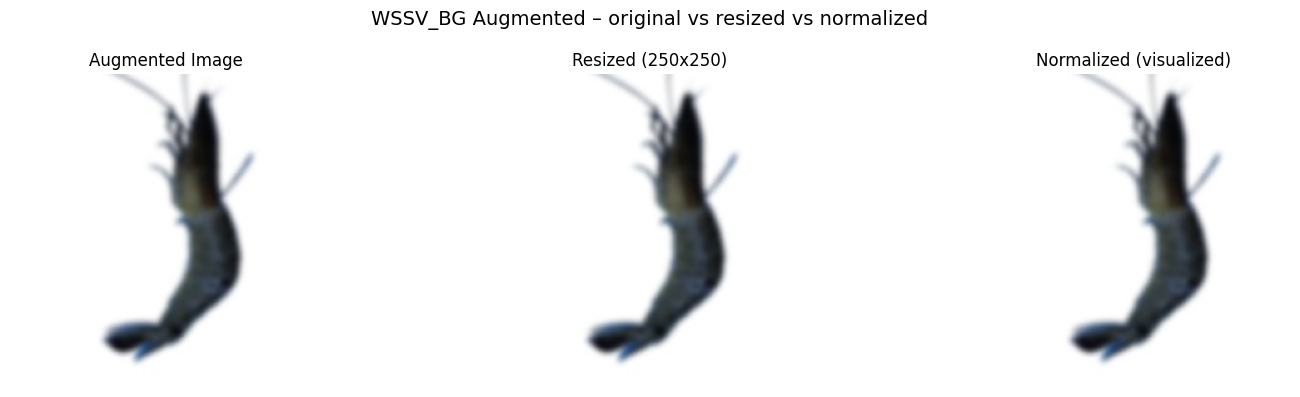

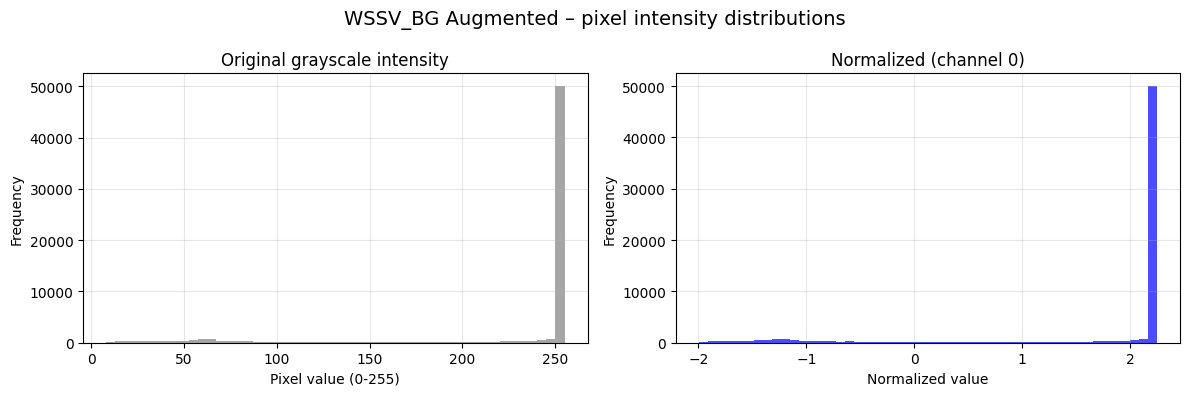


SPLITTING INTO TRAIN/TEST/VALIDATION

Splitting BG...
  Train: 1750, Test: 375, Val: 375

Splitting Healthy...
  Train: 1750, Test: 375, Val: 375

Splitting WSSV...
  Train: 1750, Test: 375, Val: 375

Splitting WSSV_BG...
  Train: 1750, Test: 375, Val: 375

SPLIT SUMMARY

BG:
  Total: 2500
  Train: 1750 (70.0%)
  Test: 375 (15.0%)
  Validation: 375 (15.0%)

Healthy:
  Total: 2500
  Train: 1750 (70.0%)
  Test: 375 (15.0%)
  Validation: 375 (15.0%)

WSSV:
  Total: 2500
  Train: 1750 (70.0%)
  Test: 375 (15.0%)
  Validation: 375 (15.0%)

WSSV_BG:
  Total: 2500
  Train: 1750 (70.0%)
  Test: 375 (15.0%)
  Validation: 375 (15.0%)

CREATING ZIP FILE
Creating augmented-ttvs.zip...
Zip file created: /kaggle/working/augmented-ttvs.zip
Size: 93.10 MB

TASK 2 COMPLETED SUCCESSFULLY!

Output: augmented-ttvs.zip
Total augmentation time: 380.79 seconds (6.35 minutes)


In [1]:
"""
Task 2: Conventional Augmentation and Train-Test-Validation Split
- Load and preprocess images (resize to 250x250, normalize)
- Apply conventional augmentation (geometric, color, filters)
- Balance classes to 1000 images each
- Split into 70% train, 15% test, 15% validation
- Create augmented-ttvs.zip
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import shutil
from sklearn.model_selection import train_test_split
import zipfile
import time
import random
from scipy import ndimage

# Configuration
IMG_SIZE = 250
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
TARGET_SAMPLES = 2500  # Target number of samples per class

# Paths
SOURCE_BASE_DIR = '/kaggle/input/elsevier-disease-shrimp-data/Elsevier_ShrimpImages/Elsevier_ShrimpImages'
WORKING_DIR = '/kaggle/working'
AUGMENTED_DIR = os.path.join(WORKING_DIR, 'augmented_data')
OUTPUT_BASE_DIR = os.path.join(WORKING_DIR, 'augmented_split')
ZIP_NAME = 'augmented-ttvs.zip'

# Class names and original sample counts
CLASSES = ['BG', 'Healthy', 'WSSV', 'WSSV_BG']
CLASS_COUNTS = {'BG': 198, 'Healthy': 403, 'WSSV': 328, 'WSSV_BG': 220}

print("="*60)
print("TASK 2: CONVENTIONAL AUGMENTATION")
print("="*60)

# Create directories
for class_name in CLASSES:
    os.makedirs(os.path.join(AUGMENTED_DIR, class_name), exist_ok=True)

# Start timing
start_time = time.time()
print(f"\nAugmentation started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")


def normalize_image(img_array):
    """Normalize image using ImageNet statistics"""
    img_array = img_array.astype(np.float32) / 255.0
    for i in range(3):
        img_array[:, :, i] = (img_array[:, :, i] - IMAGENET_MEAN[i]) / IMAGENET_STD[i]
    return img_array


def denormalize_image(img_array):
    """Denormalize for visualization"""
    img_denorm = np.copy(img_array)
    for i in range(3):
        img_denorm[:, :, i] = (img_denorm[:, :, i] * IMAGENET_STD[i]) + IMAGENET_MEAN[i]
    return np.clip(img_denorm, 0, 1)


# Augmentation functions
def augment_rotation(img):
    """Random rotation"""
    angle = random.choice([90, 120, 180, 270, 300])
    return img.rotate(angle, expand=False)


def augment_flip(img):
    """Random flip"""
    flip_type = random.choice(['horizontal', 'vertical', 'both'])
    if flip_type == 'horizontal':
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    elif flip_type == 'vertical':
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    else:
        return img.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM)


def augment_scaling(img):
    """Random scaling (zoom in/out)"""
    scale = random.uniform(0.8, 1.2)
    w, h = img.size
    new_w, new_h = int(w * scale), int(h * scale)
    img_scaled = img.resize((new_w, new_h), Image.BILINEAR)

    # Crop or pad to original size
    if scale > 1:
        left = (new_w - w) // 2
        top = (new_h - h) // 2
        img_scaled = img_scaled.crop((left, top, left + w, top + h))
    else:
        new_img = Image.new('RGB', (w, h), (128, 128, 128))
        paste_x = (w - new_w) // 2
        paste_y = (h - new_h) // 2
        new_img.paste(img_scaled, (paste_x, paste_y))
        img_scaled = new_img

    return img_scaled


def augment_translation(img):
    """Random translation"""
    w, h = img.size
    tx = random.randint(-int(w*0.1), int(w*0.1))
    ty = random.randint(-int(h*0.1), int(h*0.1))
    return img.transform(img.size, Image.AFFINE, (1, 0, tx, 0, 1, ty))


def augment_shear(img):
    """Random shear transformation"""
    shear_factor = random.uniform(-0.2, 0.2)
    return img.transform(img.size, Image.AFFINE, (1, shear_factor, 0, 0, 1, 0))


def augment_brightness(img):
    """Random brightness adjustment"""
    factor = random.uniform(0.7, 1.3)
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)


def augment_contrast(img):
    """Random contrast adjustment"""
    factor = random.uniform(0.8, 1.2)
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)


def augment_saturation(img):
    """Random saturation adjustment"""
    factor = random.uniform(0.8, 1.2)
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(factor)


def augment_hue(img):
    """Random hue shift (simulated via color enhancement)"""
    # PIL doesn't have direct hue adjustment, use saturation as proxy
    factor = random.uniform(0.9, 1.1)
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(factor)


def augment_blur(img):
    """Apply Gaussian blur"""
    radius = random.uniform(0.5, 2.0)
    return img.filter(ImageFilter.GaussianBlur(radius))


def augment_sharpen(img):
    """Apply sharpening"""
    return img.filter(ImageFilter.SHARPEN)


def augment_edge_enhance(img):
    """Enhance edges"""
    return img.filter(ImageFilter.EDGE_ENHANCE)


# All augmentation functions
GEOMETRIC_AUGS = [augment_rotation, augment_flip, augment_scaling, augment_translation, augment_shear]
COLOR_AUGS = [augment_brightness, augment_contrast, augment_saturation, augment_hue]
FILTER_AUGS = [augment_blur, augment_sharpen, augment_edge_enhance]
ALL_AUGS = GEOMETRIC_AUGS + COLOR_AUGS + FILTER_AUGS


def apply_random_augmentation(img):
    """Apply random combination of augmentations"""
    # Randomly select number of augmentations to apply
    num_augs = random.randint(1, 3)
    augs_to_apply = random.sample(ALL_AUGS, num_augs)

    for aug_func in augs_to_apply:
        try:
            img = aug_func(img)
        except:
            pass

    return img


# Demonstrate augmentation techniques on one sample
print("\n" + "="*60)
print("DEMONSTRATING AUGMENTATION TECHNIQUES")
print("="*60)

# Pick one sample from Healthy class for demonstration
demo_class = 'Healthy'
demo_dir = os.path.join(SOURCE_BASE_DIR, demo_class)
demo_files = [f for f in os.listdir(demo_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if demo_files:
    demo_img_path = os.path.join(demo_dir, demo_files[0])
    demo_img = Image.open(demo_img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)

    # Show original
    plt.figure(figsize=(6, 6))
    plt.imshow(demo_img)
    plt.title(f"Original {demo_class} Image", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Show each augmentation type
    augmentation_demos = [
        ("Rotation", augment_rotation),
        ("Horizontal Flip", lambda x: x.transpose(Image.FLIP_LEFT_RIGHT)),
        ("Scaling (Zoom)", augment_scaling),
        ("Translation", augment_translation),
        ("Shear", augment_shear),
        ("Brightness Adjustment", augment_brightness),
        ("Contrast Adjustment", augment_contrast),
        ("Saturation Adjustment", augment_saturation),
        ("Blur", augment_blur),
        ("Sharpen", augment_sharpen),
        ("Edge Enhancement", augment_edge_enhance),
    ]

    for aug_name, aug_func in augmentation_demos:
        plt.figure(figsize=(6, 6))
        try:
            aug_img = aug_func(demo_img.copy())
            plt.imshow(aug_img)
            plt.title(f"{demo_class} - {aug_name}", fontsize=14)
        except Exception as e:
            plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
            plt.title(f"{demo_class} - {aug_name} (Error)", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# Process each class
print("\n" + "="*60)
print("AUGMENTING DATASET")
print("="*60)

augmentation_stats = {}

for class_name in CLASSES:
    print(f"\n{'='*50}")
    print(f"Processing class: {class_name}")
    print(f"{'='*50}")

    source_class_dir = os.path.join(SOURCE_BASE_DIR, class_name)
    target_class_dir = os.path.join(AUGMENTED_DIR, class_name)

    if not os.path.exists(source_class_dir):
        print(f"Warning: Directory {source_class_dir} does not exist. Skipping...")
        continue

    # Get all original images
    original_files = [f for f in os.listdir(source_class_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Original images: {len(original_files)}")
    print(f"Target images: {TARGET_SAMPLES}")
    print(f"Need to generate: {TARGET_SAMPLES - len(original_files)} augmented images")

    # Copy and resize original images
    print("Copying original images...")
    for idx, fname in enumerate(original_files):
        src = os.path.join(source_class_dir, fname)

        # Keep original filename
        dst = os.path.join(target_class_dir, fname)

        try:
            img = Image.open(src).convert('RGB')
            img_resized = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            img_resized.save(dst, quality=95)
        except Exception as e:
            print(f"Error processing {fname}: {e}")

    # Generate augmented images
    num_to_generate = TARGET_SAMPLES - len(original_files)
    if num_to_generate > 0:
        print(f"Generating {num_to_generate} augmented images...")

        for i in range(num_to_generate):
            # Randomly select a source image
            source_file = random.choice(original_files)
            source_path = os.path.join(source_class_dir, source_file)

            try:
                img = Image.open(source_path).convert('RGB')
                img_resized = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)

                # Apply augmentation
                img_aug = apply_random_augmentation(img_resized)

                # Save with new name
                aug_filename = f"{class_name}-conv-aug-img-{i+1}.jpg"
                aug_path = os.path.join(target_class_dir, aug_filename)
                img_aug.save(aug_path, quality=95)

                if (i + 1) % 100 == 0:
                    print(f"  Generated {i+1}/{num_to_generate} images...")
            except Exception as e:
                print(f"Error generating augmented image {i+1}: {e}")

    final_count = len(os.listdir(target_class_dir))
    augmentation_stats[class_name] = {
        'original': len(original_files),
        'augmented': num_to_generate,
        'total': final_count
    }

    print(f"Class {class_name} completed! Total images: {final_count}")


# End timing
end_time = time.time()
elapsed_time = end_time - start_time

print("\n" + "="*60)
print("AUGMENTATION TIMING")
print("="*60)
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")
print(f"End time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")


# Visualize distribution comparison
print("\n" + "="*60)
print("VISUALIZING DATA DISTRIBUTION")
print("="*60)

fig, ax = plt.subplots(figsize=(12, 6))

classes = list(augmentation_stats.keys())
original_counts = [augmentation_stats[c]['original'] for c in classes]
total_counts = [augmentation_stats[c]['total'] for c in classes]

x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, original_counts, width, label='Original Images', color='#fc0328', alpha=0.8)
bars2 = ax.bar(x + width/2, total_counts, width, label='After Augmentation', color='#0c06c7', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Image Distribution: Original vs Augmented', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# Visualize preprocessing pipeline for augmented images
print("\n" + "="*60)
print("VISUALIZING AUGMENTED IMAGE PREPROCESSING")
print("="*60)

for class_name in CLASSES:
    class_dir = os.path.join(AUGMENTED_DIR, class_name)
    aug_files = [f for f in os.listdir(class_dir) if 'conv-aug' in f]

    if aug_files:
        # Pick first augmented image
        sample_path = os.path.join(class_dir, aug_files[0])

        # Load images
        original = Image.open(sample_path).convert('RGB')
        original_array = np.array(original)
        normalized_array = normalize_image(original_array.copy())
        display_normalized = denormalize_image(normalized_array)

        # Plot images
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f"{class_name} Augmented – original vs resized vs normalized", fontsize=14)

        axes[0].imshow(original_array)
        axes[0].set_title("Augmented Image")
        axes[0].axis('off')

        axes[1].imshow(original_array)
        axes[1].set_title(f"Resized ({IMG_SIZE}x{IMG_SIZE})")
        axes[1].axis('off')

        axes[2].imshow(display_normalized)
        axes[2].set_title("Normalized (visualized)")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        # Plot histograms
        original_gray = np.array(original.convert('L')).flatten()
        normalized_ch0 = normalized_array[:, :, 0].flatten()

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"{class_name} Augmented – pixel intensity distributions", fontsize=14)

        axes[0].hist(original_gray, bins=50, color='gray', alpha=0.7)
        axes[0].set_title("Original grayscale intensity")
        axes[0].set_xlabel("Pixel value (0-255)")
        axes[0].set_ylabel("Frequency")
        axes[0].grid(True, alpha=0.3)

        axes[1].hist(normalized_ch0, bins=50, color='blue', alpha=0.7)
        axes[1].set_title("Normalized (channel 0)")
        axes[1].set_xlabel("Normalized value")
        axes[1].set_ylabel("Frequency")
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# Split into train/test/validation
print("\n" + "="*60)
print("SPLITTING INTO TRAIN/TEST/VALIDATION")
print("="*60)

for split in ['train', 'test', 'validation']:
    for class_name in CLASSES:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, split, class_name), exist_ok=True)

split_stats = {}

for class_name in CLASSES:
    print(f"\nSplitting {class_name}...")

    class_dir = os.path.join(AUGMENTED_DIR, class_name)
    all_files = os.listdir(class_dir)

    # Split: 70% train, 15% test, 15% validation
    train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
    test_files, val_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    split_stats[class_name] = {
        'total': len(all_files),
        'train': len(train_files),
        'test': len(test_files),
        'validation': len(val_files)
    }

    # Copy files
    for split, files in [('train', train_files), ('test', test_files), ('validation', val_files)]:
        for fname in files:
            src = os.path.join(class_dir, fname)
            dst = os.path.join(OUTPUT_BASE_DIR, split, class_name, fname)
            shutil.copy(src, dst)

    print(f"  Train: {len(train_files)}, Test: {len(test_files)}, Val: {len(val_files)}")


# Print summary
print("\n" + "="*60)
print("SPLIT SUMMARY")
print("="*60)

for class_name in CLASSES:
    if class_name in split_stats:
        stats = split_stats[class_name]
        print(f"\n{class_name}:")
        print(f"  Total: {stats['total']}")
        print(f"  Train: {stats['train']} ({stats['train']/stats['total']*100:.1f}%)")
        print(f"  Test: {stats['test']} ({stats['test']/stats['total']*100:.1f}%)")
        print(f"  Validation: {stats['validation']} ({stats['validation']/stats['total']*100:.1f}%)")


# Create zip file
print("\n" + "="*60)
print("CREATING ZIP FILE")
print("="*60)

zip_path = os.path.join(WORKING_DIR, ZIP_NAME)
print(f"Creating {ZIP_NAME}...")

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for split in ['train', 'test', 'validation']:
        for class_name in CLASSES:
            split_dir = os.path.join(OUTPUT_BASE_DIR, split, class_name)
            if os.path.exists(split_dir):
                for fname in os.listdir(split_dir):
                    file_path = os.path.join(split_dir, fname)
                    arcname = os.path.join(split, class_name, fname)
                    zipf.write(file_path, arcname)

print(f"Zip file created: {zip_path}")
print(f"Size: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")

print("\n" + "="*60)
print("TASK 2 COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nOutput: {ZIP_NAME}")
print(f"Total augmentation time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")